In [ ]:
'''
WAY TO OPEN THE FILE IF YOU USE GOOGLE COLAB 

# 1) Install the library
!pip install kagglehub[pandas-datasets]

# 2) Import and load
import kagglehub
from kagglehub import KaggleDatasetAdapter

# 3) Specify the path *inside* the Kaggle dataset you want to read.
#    In this case the CSV is named “Video_Games_Sales_as_at_22_Dec_2016.csv”
file_path = "Video_Games_Sales_as_at_22_Dec_2016.csv"

# 4) Load into a pandas DataFrame
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "rush4ratio/video-game-sales-with-ratings",
    file_path
)
'''

Hypothesis testing and Confidence Intervals

In [34]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


# Load your cleaned DataFrame (df) 

df = pd.read_csv(r'D:\Sxoli\Applies Statistics\Project\Video_Games_Sales_as_at_22_Dec_2016.csv')


#Define “High” vs. “Low” Critic_Score groups.

median_score = df['Critic_Score'].median()
high_mask = df['Critic_Score'] > median_score
low_mask  = df['Critic_Score'] <= median_score

# Extract Global_Sales for each group (and drop any missing values):

sales_high = df.loc[high_mask, 'Global_Sales'].dropna()
sales_low  = df.loc[low_mask,  'Global_Sales'].dropna()


# Summary statistics for each group

n_high = len(sales_high)
n_low  = len(sales_low)

mean_high = sales_high.mean()
mean_low  = sales_low.mean()

std_high = sales_high.std(ddof=1)  # sample standard deviation
std_low  = sales_low.std(ddof=1)

print(f"High‐Critic‐Score group (n = {n_high}):  mean = {mean_high:.3f},  std = {std_high:.3f}")
print(f"Low‐Critic‐Score  group (n = {n_low}):   mean = {mean_low:.3f},   std = {std_low:.3f}")


# Two‐sample t-test (unequal variances by default)
# 
#   H₀: μ_high − μ_low = 0   (no difference in mean sales)
#   H₁: μ_high − μ_low > 0   (high‐score games have greater mean sales)



t_stat, p_two_sided = stats.ttest_ind(
    sales_high,
    sales_low,
    equal_var=False,      # Welch’s t-test (unequal variances)
    nan_policy='omit'
)

# Convert to one‐tailed p-value:
p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - p_two_sided / 2

print(f"\nWelch’s t‐statistic = {t_stat:.3f}")
print(f"One‐tailed p‐value (high > low) = {p_one_sided:.5f}")






High‐Critic‐Score group (n = 3865):  mean = 1.081,  std = 2.454
Low‐Critic‐Score  group (n = 4272):   mean = 0.334,   std = 0.759

Welch’s t‐statistic = 18.166
One‐tailed p‐value (high > low) = 0.00000


In [3]:

# 95 % Confidence Interval for (μ_high − μ_low)
#
#   Approximate CI for difference of means (unequal‐variance case):
#     (μ_high − μ_low) ≈ (ȳ_high − ȳ_low) ± t_* × SE_diff
#   where SE_diff = sqrt( s_high²/n_high + s_low²/n_low )


# Compute standard error of (ȳ_high − ȳ_low):
SE_diff = np.sqrt(std_high**2 / n_high + std_low**2 / n_low)

# Degrees of freedom (Welch–Satterthwaite):
df_num = (std_high**2 / n_high + std_low**2 / n_low)**2
df_den = ( (std_high**2 / n_high)**2 / (n_high - 1)
         + (std_low**2  / n_low )**2 / (n_low  - 1) )
df_welch = df_num / df_den

# t‐critical value for 95 % two-sided CI:
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df_welch)

# Point estimate of difference:
diff_means = mean_high - mean_low

CI_lower = diff_means - t_crit * SE_diff
CI_upper = diff_means + t_crit * SE_diff

print(f"\n95% CI for (μ_high − μ_low): ({CI_lower:.3f}, {CI_upper:.3f})")



#Interpretation 
#
# 1. If p_one_sided < 0.05, we reject H₀ and conclude “High critique games sell
#    significantly more, on average, than low critique games.” Otherwise we fail
#    to reject H₀.
#
# 2. The 95% CI tells us the plausible range for (μ_high − μ_low).  If 0 is not
#    inside that interval, that also supports a significant difference.


if p_one_sided < 0.05:
    print("\nResult: Reject H₀.  High‐Critic‐Score games have significantly higher mean Global Sales.")
else:
    print("\nResult: Fail to reject H₀.  No evidence that High‐Critic‐Score games sell more on average.")



95% CI for (μ_high − μ_low): (0.667, 0.828)

Result: Reject H₀.  High‐Critic‐Score games have significantly higher mean Global Sales.


CI for sales vs genre 

           Genre     n   mean    std  CI_lower  CI_upper
0         Action  3370  0.518  1.145     0.479     0.557
10        Sports  2348  0.567  2.084     0.483     0.652
3           Misc  1750  0.459  1.305     0.398     0.520
7   Role-Playing  1500  0.623  1.709     0.536     0.710
8        Shooter  1323  0.796  1.816     0.698     0.894
1      Adventure  1303  0.182  0.508     0.155     0.210
6         Racing  1249  0.584  1.657     0.492     0.676
4       Platform   888  0.933  2.574     0.763     1.102
9     Simulation   874  0.447  1.186     0.368     0.525
2       Fighting   849  0.527  0.952     0.463     0.591
11      Strategy   683  0.255  0.519     0.216     0.294
5         Puzzle   580  0.419  1.562     0.292     0.546


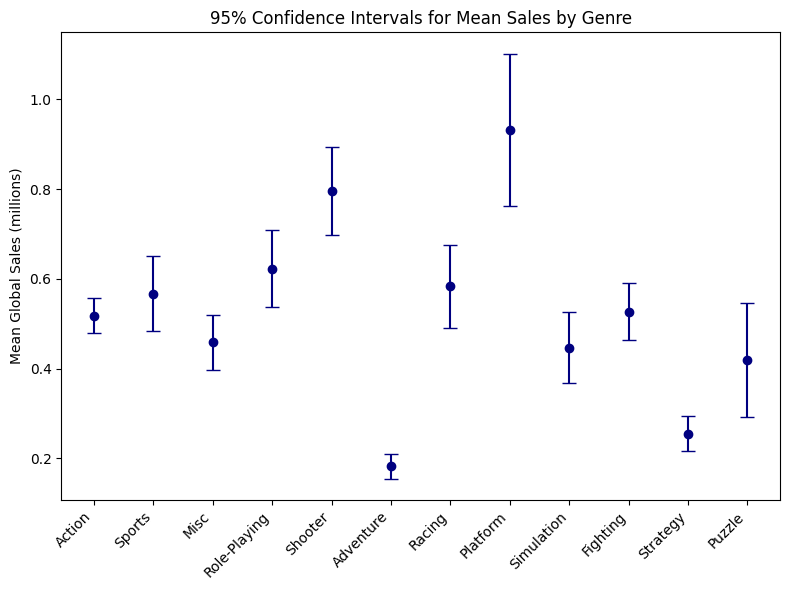

In [4]:
# Preview and clean: keep only rows where Global_Sales is not null
df = df.dropna(subset=["Global_Sales", "Genre"])

# Group by Genre and compute sample statistics
grouped = df.groupby("Genre")["Global_Sales"].agg(
    n="count",
    mean="mean",
    std="std"
).reset_index()

# Compute 95% confidence interval for each genre
def compute_ci(row, confidence=0.95):
    n = row["n"]
    mean = row["mean"]
    std = row["std"]
    if n < 2 or pd.isna(std):
        return (np.nan, np.nan)
    # degrees of freedom = n - 1
    dfree = n - 1
    # t* for two‐sided (1-alpha/2)
    t_star = stats.t.ppf((1 + confidence) / 2, dfree)
    se = std / np.sqrt(n)
    margin = t_star * se
    return (mean - margin, mean + margin)

# Apply the function to each row, returning two new columns CI_lower, CI_upper
grouped[["CI_lower", "CI_upper"]] = grouped.apply(
    compute_ci, axis=1, result_type="expand"
)

# Sort by descending sample size (or by mean if preferred)
grouped = grouped.sort_values("n", ascending=False)

# 6. Display the results as a table
pd.set_option("display.precision", 3)
print(grouped[["Genre", "n", "mean", "std", "CI_lower", "CI_upper"]])



# # Only keep genres with n >=, say, 30 to ensure CLT is reasonable
filtered = grouped[grouped["n"] >= 30]

genres = filtered["Genre"]
means = filtered["mean"]
lower = filtered["CI_lower"]
upper = filtered["CI_upper"]
errors = [means - lower, upper - means]  # symmetric margins

plt.figure(figsize=(8, 6))
plt.errorbar(
    x=np.arange(len(genres)),
    y=means,
    yerr=np.array(errors),
    fmt="o",
    capsize=5,
    color="navy"
)
plt.xticks(np.arange(len(genres)), genres, rotation=45, ha="right")
plt.ylabel("Mean Global Sales (millions)")
plt.title("95% Confidence Intervals for Mean Sales by Genre")
plt.tight_layout()
plt.show()

Analysis of Variance (ANOVA)

In [5]:
# Drop any rows where Global_Sales, Genre, or Platform is missing
df = df.dropna(subset=["Global_Sales", "Genre", "Platform"])

# Restrict to the top N most‐common platforms
#so the ANOVA isn’t overwhelmed by hundreds of tiny groups.
top_platforms = df["Platform"].value_counts().nlargest(10).index
df_top = df[df["Platform"].isin(top_platforms)].copy()


# ONE‐WAY ANOVA BY GENRE


# Group Global_Sales by Genre into a list of arrays
groups_by_genre = [group["Global_Sales"].values
                   for _, group in df.groupby("Genre")]

# Run one‐way ANOVA (scipy.stats.f_oneway):
f_genre, p_genre = stats.f_oneway(*groups_by_genre)

print("ANOVA by Genre:")
print(f"  F‐statistic = {f_genre:.3f}")
print(f"  p‐value      = {p_genre:.6f}\n")


# ONE‐WAY ANOVA BY PLATFORM (TOP 10)
# Group Global_Sales by Platform (limiting to top 10)
groups_by_platform = [group["Global_Sales"].values
                      for _, group in df_top.groupby("Platform")]

# Run one‐way ANOVA
f_platform, p_platform = stats.f_oneway(*groups_by_platform)

print("ANOVA by Top 10 Platforms:")
print(f"  F‐statistic = {f_platform:.3f}")
print(f"  p‐value      = {p_platform:.6f}")


# SUMMARY OF GROUP MEANS / COUNTS


# For reference, show each genre’s sample size and mean
genre_summary = (
    df.groupby("Genre")["Global_Sales"]
      .agg(["count", "mean", "std"])
      .sort_values("mean", ascending=False)
)
print("\nGenre summary (count, mean, std):")
print(genre_summary)

#Similarly, platform summary for top 10
platform_summary = (
    df_top.groupby("Platform")["Global_Sales"]
          .agg(["count", "mean", "std"])
          .sort_values("mean", ascending=False)
)
print("\nPlatform summary (top 10) (count, mean, std):")
print(platform_summary)


ANOVA by Genre:
  F‐statistic = 18.747
  p‐value      = 0.000000

ANOVA by Top 10 Platforms:
  F‐statistic = 21.758
  p‐value      = 0.000000

Genre summary (count, mean, std):
              count   mean    std
Genre                            
Platform        888  0.933  2.574
Shooter        1323  0.796  1.816
Role-Playing   1500  0.623  1.709
Racing         1249  0.584  1.657
Sports         2348  0.567  2.084
Fighting        849  0.527  0.952
Action         3370  0.518  1.145
Misc           1750  0.459  1.305
Simulation      874  0.447  1.186
Puzzle          580  0.419  1.562
Strategy        683  0.255  0.519
Adventure      1303  0.182  0.508

Platform summary (top 10) (count, mean, std):
          count   mean    std
Platform                     
X360       1262  0.770  1.615
PS3        1331  0.706  1.392
Wii        1320  0.688  3.126
PS         1197  0.610  1.054
PS2        2161  0.581  1.138
GBA         822  0.387  0.897
DS         2152  0.375  1.426
XB          824  0.313  0.534


 Multiple Linear Regression

In [17]:
# Convert categorical columns to “category” dtype
df = df.dropna(subset=['Global_Sales', 'Genre', 'Platform', 'Rating', 'Critic_Score', 'User_Score'])


df['Genre'] = df['Genre'].astype('category')
df['Platform'] = df['Platform'].astype('category')
df['Rating'] = df['Rating'].astype('category')

#  Build a formula string for statsmodels
#  We include one-hot encoding by wrapping categorical variables in C(...)
formula = 'Global_Sales ~ C(Genre) + C(Platform) + C(Rating) + Critic_Score + User_Score'

#  Fit the OLS regression
model = ols(formula, data=df).fit()

# Print a summary of results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     9.134
Date:                Wed, 04 Jun 2025   Prob (F-statistic):          1.55e-148
Time:                        20:08:15   Log-Likelihood:                -15689.
No. Observations:                8025   AIC:                         3.163e+04
Df Residuals:                    7901   BIC:                         3.249e+04
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

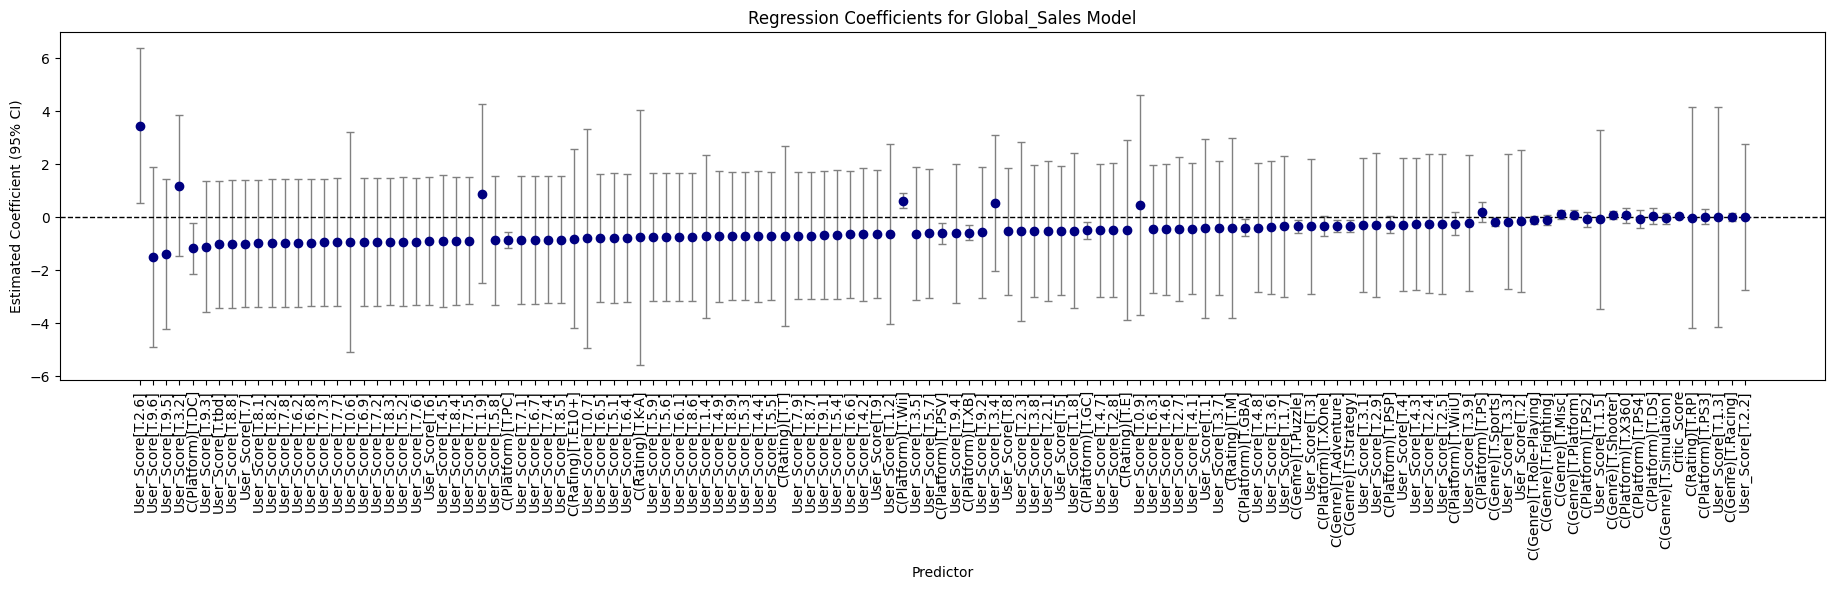

In [ ]:
# Sort by absolute coefficient magnitude so the largest‐impact predictors
# appear near the center of the chart, easing readability:
coef_df = coef_df.assign(abs_coef=coef_df["coef"].abs())
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Now, build a vertical‐orientation error‐bar plot:
plt.figure(figsize=(max(8, len(coef_df)*0.15), 6))  


# Call errorbar, placing the errorbars vertically:
plt.errorbar(
    x=coef_df.index,              # x = predictor names
    y=coef_df["coef"],            # y = coefficient estimate
    yerr=[
        coef_df["coef"] - coef_df["ci_lower"],  # downward CI length
        coef_df["ci_upper"] - coef_df["coef"]   # upward CI length
    ],
    fmt='o',                      # mark each estimate as a dot
    color='navy',                 # dot color
    ecolor='grey',                # error‐bar color
    elinewidth=1.0,
    capsize=3
)

# Draw the horizontal “zero‐effect” line at y = 0:
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Label axes and title:
plt.ylabel("Estimated Coefficient (95% CI)")
plt.xlabel("Predictor")
plt.title("Regression Coefficients for Global_Sales Model")

# Rotate x‐labels so they don’t overlap horizontally:
plt.xticks(rotation=90, ha="center", fontsize=10)

# Tighten layout to avoid clipping:
plt.tight_layout()

plt.show()

Logistic Regression   'Global_Sales', 'Genre', 'Platform', 'Rating', 'Critic_Score', 'User_Score'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


#  Convert scores to numeric
df["Critic_Score"] = pd.to_numeric(df["Critic_Score"], errors="coerce")
df["User_Score"]   = pd.to_numeric(df["User_Score"],   errors="coerce")

#  Define binary target: 1 if Global_Sales > 1.0 million, else 0
df["Successful"] = (df["Global_Sales"] > 1.0).astype(int)

#  Drop any row missing any of our five predictors or the target
df_clean = df.dropna(subset=["Genre", "Platform", "Rating", "Critic_Score", "User_Score", "Successful"])

#  One‐hot‐encode exactly those three categoricals (Genre, Platform, Rating),
#  dropping the first category in each so we don’t introduce multicollinearity.
df_ohe = pd.get_dummies(
    df_clean,
    columns=["Genre", "Platform", "Rating"],
    drop_first=True
)

#  Build X by selecting the predectors:
predictor_cols = ["Critic_Score", "User_Score"] + [
    col for col in df_ohe.columns
    if col.startswith("Genre_") or col.startswith("Platform_") or col.startswith("Rating_")
]

X = df_ohe[predictor_cols]
y = df_ohe["Successful"]

# 7. Train/test split 75/25
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 8. Fit logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 9. Evaluate on test set
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"Test ROC AUC: {roc_auc:.3f}")





Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.850     0.960     0.902      1391
           1      0.665     0.321     0.433       346

    accuracy                          0.832      1737
   macro avg      0.757     0.640     0.667      1737
weighted avg      0.813     0.832     0.808      1737

Test ROC AUC: 0.813
